In [128]:
import pandas as pd
from copy import deepcopy
import torch
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, Pipeline, pipeline

In [3]:
import os
print("models live at: ", os.environ["HF_HOME"])


models live at:  /shared_data0/jrudoler/.cache/huggingface/


In [4]:
# Load model directly
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True

In [33]:
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     torch_dtype=torch.bfloat16,
#     device="cuda",
# )

## Create data for learning basic functions 

In [4]:
# Generate random data for OLS

def generate_dataset(n_samples: int, f, x_std: float, noise_std: float):
    x = np.random.randn(n_samples) * x_std
    y = f(x) + np.random.randn(n_samples) * noise_std
    return pd.DataFrame({"x": x, "y": y})

def linear_model(x, slope: float, intercept: float):
    return slope * x + intercept

def quadratic_model(x, a: float, b: float, c: float):
    return a * x**2 + b * x + c

def log_model(x, a: float, b: float):
    return a * np.log(x) + b

def exp_model(x, a: float, b: float):
    return a * np.exp(b * x)

# Example usage
n_samples = 100
slope = 3
intercept = 2
x_std = 1
noise_std = 0.05

dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
print(dataset.head())

          x         y
0 -0.438198  0.658704
1 -0.359752  0.958411
2 -0.844788 -0.483550
3 -0.363466  0.837757
4  0.738539  4.167950


In [5]:
# helper function to create a list of messages from a dataset
def create_few_shot_messages(dataset: pd.DataFrame):
    """
    Given a dataframe with columns "x" and "y", create a list of messages for the model.
    If there are m rows, the first m-1 rows will be used as few-shot examples 
    and the last row will be the target example.
    """
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
        messages.append({"role": "assistant", "content": f"{row['y']}"})
    return messages

def create_query_messages(dataset: pd.DataFrame):
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
    return messages

dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
few_shot_messages = create_few_shot_messages(dataset)
query_messages = create_query_messages(dataset)
print(few_shot_messages)
print(query_messages)

[{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'content': '5.7696817793460795'}, {'role': 'user', 'content': 'x = -0.9749501354738932

In [14]:
messages = few_shot_messages + query_messages[0:1]
pipe.model.generation_config.pad_token_id = tokenizer.eos_token_id
pipe.model.generation_config.return_dict_in_generate = True
pipe.model.generation_config.output_scores = True
outputs = pipe(
    messages,
    max_length=5000,
    pad_token_id=tokenizer.eos_token_id,
)
print(messages[-1])
print(outputs[0])

{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}
{'generated_text': [{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'conte

In [5]:
def prompt_and_predict(messages: list[dict], pipeline : Pipeline):
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.return_dict_in_generate = True
    outputs = pipeline(
        messages,
        max_length=5000,
        pad_token_id=pipeline.tokenizer.eos_token_id,
        output_scores=True
    )
    return outputs #[0]["generated_text"][-1]

In [80]:
ols = LinearRegression()
ols.fit(dataset["x"].values.reshape(-1, 1), dataset["y"].values)

ols.predict(dataset["x"].iloc[-1].reshape(1, -1))

array([1.17567767])

In [104]:
res = prompt_and_predict(few_shot_messages + query_messages[0:1], pipe)

In [107]:
res[0]

{'generated_text': [{'role': 'user',
   'content': 'x = -0.45903432938493827; y = ?'},
  {'role': 'assistant', 'content': '0.6400286257124784'},
  {'role': 'user', 'content': 'x = -0.7640071102714826; y = ?'},
  {'role': 'assistant', 'content': '-0.3166311849470841'},
  {'role': 'user', 'content': 'x = 2.39709748832622; y = ?'},
  {'role': 'assistant', 'content': '9.193544841312868'},
  {'role': 'user', 'content': 'x = -0.5033711887173068; y = ?'},
  {'role': 'assistant', 'content': '0.5073557515539322'},
  {'role': 'user', 'content': 'x = 0.37005520438959516; y = ?'},
  {'role': 'assistant', 'content': '3.180338410926132'},
  {'role': 'user', 'content': 'x = 0.520129111076402; y = ?'},
  {'role': 'assistant', 'content': '3.4983364943523214'},
  {'role': 'user', 'content': 'x = -1.4774222656568894; y = ?'},
  {'role': 'assistant', 'content': '-2.3957641491933366'},
  {'role': 'user', 'content': 'x = -0.28323129890452364; y = ?'},
  {'role': 'assistant', 'content': '1.0953330439664344'}

In [94]:
input = tokenizer.encode("x = 1; y = ?", return_tensors="pt").to("cuda")
model.generate(input, max_new_tokens=256, output_scores=True)
# print(tokenizer.decode([-1]))


GenerateDecoderOnlyOutput(sequences=tensor([[128000,     87,    284,    220,     16,     26,    379,    284,    949,
             26,   1167,    284,    865,    489,    379,    280,     88,    284,
            220,     20,     26,   1167,    284,    865,    489,    379,    280,
             88,    284,    220,    605,     26,   1167,    284,    865,    489,
            379,    280,     88,    284,    220,    508,     26,   1167,    284,
            865,    489,    379,    280,     88,    284,    220,    966,     26,
           1167,    284,    865,    489,    379,    280,     88,    284,    220,
           1272,     26,   1167,    284,    865,    489,    379,    280,     88,
            284,    220,   1135,     26,   1167,    284,    865,    489,    379,
            280,     88,    284,    220,   1399,     26,   1167,    284,    865,
            489,    379,    280,     88,    284,    220,   2031,     26,   1167,
            284,    865,    489,    379,    280,     88,    284,    220, 

In [73]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

few_shot_messages = create_few_shot_messages(train_dataset)
query_messages = create_query_messages(test_dataset)

for i, test_row in test_dataset.reset_index().iterrows():
    print(i, query_messages[i:i+1])
    full_prompt_messages = few_shot_messages + query_messages[i:i+1]
    pred = prompt_and_predict(full_prompt_messages, pipe)
    print(pred)
    print(f"x = {test_row['x']}; y = {test_row['y']}; pred = {pred}")


0 [{'role': 'user', 'content': 'x = -1.5047226363170778; y = ?'}]
{'role': 'assistant', 'content': '-2.1610111244455165'}
x = -1.5047226363170778; y = -2.457422877718286; pred = {'role': 'assistant', 'content': '-2.1610111244455165'}
1 [{'role': 'user', 'content': 'x = -0.9317807036702849; y = ?'}]
{'role': 'assistant', 'content': '-0.6956379113301794'}
x = -0.9317807036702849; y = -0.8476896227162707; pred = {'role': 'assistant', 'content': '-0.6956379113301794'}
2 [{'role': 'user', 'content': 'x = -0.04854387364964442; y = ?'}]
{'role': 'assistant', 'content': '1.9119265559560114'}
x = -0.04854387364964442; y = 1.8174565677505468; pred = {'role': 'assistant', 'content': '1.9119265559560114'}
3 [{'role': 'user', 'content': 'x = 1.1076373389582772; y = ?'}]
{'role': 'assistant', 'content': '5.33478610955586'}
x = 1.1076373389582772; y = 5.269385592413651; pred = {'role': 'assistant', 'content': '5.33478610955586'}
4 [{'role': 'user', 'content': 'x = -0.46746945950087276; y = ?'}]
{'rol

### SST-2

In [79]:
## NOTE LLAMA HAS THE FOLLOWING DEFAULT CONFIG:
# {
#   "_from_model_config": true,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "transformers_version": "4.45.0.dev0",
#   "do_sample": true,
#   "temperature": 0.6,
#   "top_p": 0.9
# }

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "output_scores": true,
  "pad_token_id": 128009,
  "return_dict_in_generate": true,
  "temperature": 0.6,
  "top_p": 0.9
}

In [156]:
###SST-2
import polars as pl

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
sst2_train = pl.read_parquet('hf://datasets/stanfordnlp/sst2/' + splits['train'])
sst2_test = pl.read_parquet('hf://datasets/stanfordnlp/sst2/' + splits['validation'])


In [157]:
# Load model directly
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
print("Original model.generation_config:\n", model.generation_config)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True
model.generation_config.do_sample = False
model.generation_config.temperature = None
model.generation_config.top_p = None
print("Updated model.generation_config:\n", model.generation_config)

Original model.generation_config:
 GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}

Updated model.generation_config:
 GenerationConfig {
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "output_scores": true,
  "pad_token_id": 128009,
  "return_dict_in_generate": true,
  "temperature": null,
  "top_p": null
}



In [158]:
print(tokenizer.pad_token_id)
print(tokenizer.eos_token_id)

128009
128009


In [159]:
def create_sst2_messages(df: pl.DataFrame):
    messages = []
    for row in df[:-1].iter_rows(named=True):
        messages.append({"role": "user", "content": f"{row['sentence']}"})
        messages.append({"role": "assistant", "content": f"{row['label']}"})
    messages.append({"role": "user", "content": f"{df[-1, 'sentence']}"})
    return messages
        


In [160]:
model.to("cuda")
sst2_samples = sst2_train.sample(100, seed=42)
sst2_messages = create_sst2_messages(sst2_samples)
sst2_prompt = tokenizer.apply_chat_template(
    sst2_messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
).to("cuda")
outputs = model.generate(
    sst2_prompt, 
    max_new_tokens=10, 
    output_scores=True, 
    output_logits=True, 
    renormalize_logits=True, 
)
## NOTE: the last token is the EOS token, so we need to decode the last two tokens
## 'sequences' is of shape (n_beams, n_tokens), but we only have one beam so can just index [0]
## 'scores' is of shape (n_tokens, n_vocab)
print("pred: ", tokenizer.decode(outputs['sequences'][0][-2:], skip_special_tokens=True))
print("target: ", sst2_samples['label'][-1])
print("prob: ", torch.softmax(outputs['logits'][0], dim=-1).max().cpu().item())



pred:  1
target:  0
prob:  0.742005467414856


In [161]:
def create_few_shot_sst2_messages(df_context: pl.DataFrame, df_target: pl.DataFrame) -> list[list[dict]]:
    """
    Create few-shot prompt messages for the SST-2 dataset, with shared context but different target sentences.
    """
    messages = []
    for row in df_context.iter_rows(named=True):
        messages.append({"role": "user", "content": f"{row['sentence']}"})
        messages.append({"role": "assistant", "content": f"{row['label']}"})
    # create a copy of the messages for each target sentence
    target_messages = [deepcopy(messages) for _ in range(len(df_target))]
    for i, row in enumerate(df_target.iter_rows(named=True)):
        target_messages[i].append({"role": "user", "content": f"{row['sentence']}"})
    return target_messages

In [162]:
context_samples = sst2_train.sample(100, seed=42)
target_samples = sst2_test.sample(100, seed=42)
target_messages = create_few_shot_sst2_messages(context_samples, target_samples)

In [175]:
test_preds = []
test_probs = []
for i, messages in enumerate(target_messages):
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")
    outputs = model.generate(
        prompt, max_new_tokens=10, output_scores=True, output_logits=True, renormalize_logits=True
    )
    pred = tokenizer.decode(outputs['sequences'][0][-2:], skip_special_tokens=True)
    prob = torch.softmax(outputs['logits'][0], dim=-1).max().cpu().item()
    test_preds.append(int(pred))
    test_probs.append(prob)
    # print("##########################")
    # print(messages[-1])
    # print(tokenizer.decode(outputs['sequences'][0][-2:], skip_special_tokens=True))
    # print(target_samples[i]['label'])

In [176]:
test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = target_samples['label'].to_numpy()
np.mean(test_preds == test_labels)

np.float64(0.85)

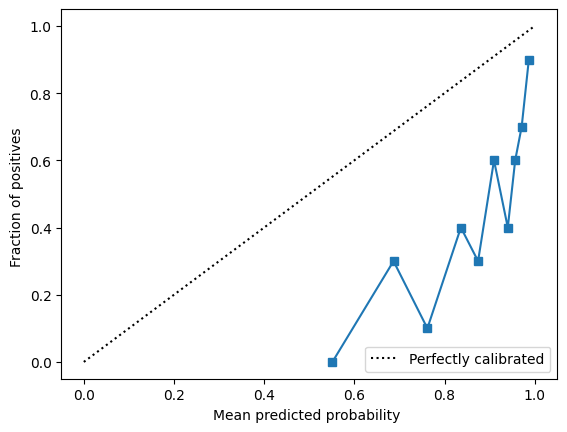

In [185]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(test_labels, test_probs, n_bins=10, strategy="quantile")
CalibrationDisplay(prob_true, prob_pred, "SST-2").plot()
plt.show()

## Basic logit testing

In [24]:
text = "Paris is the capital of "
inputs = tokenizer(text, return_tensors="pt").to("cuda")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
outputs.logits

tensor([[[ 2.8333,  3.5810,  7.0268,  ..., -1.2470, -1.2469, -1.2468],
         [11.4608,  7.7852,  5.2888,  ..., -3.2462, -3.2465, -3.2473],
         [ 5.7058,  4.9790,  5.8671,  ..., -1.8279, -1.8284, -1.8283],
         ...,
         [11.8838,  8.1722,  5.3255,  ..., -0.6236, -0.6236, -0.6234],
         [ 6.6177,  6.7700,  2.9824,  ..., -0.3406, -0.3407, -0.3406],
         [ 2.0481,  2.6027,  3.0640,  ..., -0.7406, -0.7404, -0.7407]]])

In [ ]:
outputs = pipe.model.generate(**inputs, max_new_tokens=1, output_scores=True, output_logits=True, renormalize_logits=True, temperature=0.1)

In [ ]:
tokenizer.decode(outputs['sequences'][0], skip_special_tokens=True)

'Paris is the capital of  France'

In [ ]:
torch.softmax(outputs['logits'][0], dim=-1)


tensor([[8.1281e-08, 1.4113e-09, 1.5621e-07,  ..., 4.3134e-09, 4.3146e-09,
         4.3151e-09]], device='cuda:0')

In [ ]:
tokenizer.decode(outputs['sequences'][0][-1], skip_special_tokens=True,)

' France'

In [ ]:
tokenizer.decode(torch.exp(outputs.scores[-1]).argmax(), skip_special_tokens=True)



' France'

In [ ]:
chat_inputs = tokenizer.apply_chat_template([{"role": "user", "content": "Paris is the capital of "},
                               {"role": "assistant", "content": "France"},
                               {"role": "user", "content": "What is the capital of England?"}], 
                               tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

In [ ]:
outputs = model.generate(chat_inputs, max_new_tokens=10, output_scores=True, device="cuda")
print(tokenizer.decode(outputs['sequences'][0], skip_special_tokens=True))

system

Cutting Knowledge Date: December 2023
Today Date: 01 Dec 2024

user

Paris is the capital ofassistant

Franceuser

What is the capital of England?assistant

London
